# Physics 404/604

## Computational Physics (Spring 2019)

## BPB-250, Mon./Wed. 1:00-2:15 pm

| Instructor | Prof. Zhaohuan Zhu                 |
| ---------- | :--------------------------------- |
| Email      | zhaohuan.zhu@unlv.edu              |
| Website    | http://www.physics.unlv.edu/~zhzhu |
| Office     | BPB 245                            |


# Lecture 11: Conservation Laws and Finite Volume Methods

A 1D **conservation law** in its differential form reads

\begin{equation}
  u_t(t,x) + f_x(t,x) = 0,
\end{equation}

where $u$ is the *density* of a conserved quantity, say, mass, and $f$ is the flux of that quantity, i.e., rate of something passing through a virtual boundary at position $x$.
In this case, the total mass over a fixed domain $[x_1, x_2]$

\begin{equation}
  \int_{x_1}^{x_2} u(t,x)\,\mathrm{d}x
\end{equation}

is conserved, if $f(t,x_1) = f(t,x_2) = 0$.

## Burgers' Equation Revisited

The Burgers' equation we studied in the last lecture

\begin{equation}
  u_t + u u_x = 0
\end{equation}

was *not* written—and solved—in conservative form.
However, this equation *can* be written in conservative form:

\begin{equation}
  u_t + \frac{\partial}{\partial x}\left(\frac{1}{2}u^2\right) = 0,
\end{equation}

which tells us that $u$ should be a conserved quantity.

Let's check if $u$ is conserved in our earlier simulation.

In [1]:
# Burgers' equation: non-conservative form

import numpy as np
import matplotlib.pyplot as plt

# Model Parameters
xmin = -10.0   # left boundary
xmax = +10.0   # right boundary
Nx = 101      # number of grid points (including boundary)
tend = 10.0    # end time
dtout = 1.0   # time interval for outputs

# Set up the grid.
x = np.linspace(xmin, xmax, Nx)
dx = (xmax - xmin) / (Nx - 1)
dt = 0.8 * dx

# Give the initial profile.
t = 0.0
U = 0.2 + 0.8 * np.exp(-0.5 * x**2)

# Initiate the plot.
fig = plt.figure(figsize=(16,10))
ax = fig.gca()
ax.plot(x, U, label=r"$t = {:.3G}$".format(t))
ax.set_xlabel(r"Position $x$")
ax.set_ylabel(r"$U(t,x)$")
ax.minorticks_on()

# Begin the simulation.
tout = t + dtout
while t < tend:
    # Backup the previous time step.
    Uold = np.copy(U)

    # Find the state at the next time step, using upwind method.
    for ix in range(1, Nx - 1):
        vel = Uold[ix]
        if vel > 0:
            U[ix] = Uold[ix] - vel * dt / dx * (Uold[ix] - Uold[ix-1])
        else:
            U[ix] = Uold[ix] - vel * dt / dx * (Uold[ix+1] - Uold[ix])
    t += dt

    # Monitor total U after every dtout.
    if t >= tout:
        plt.plot(x, U, label=r"$t = {:.3G}$".format(t))
        print("t, sum(U) = {:>6.3f}, {:>18.15e}".format(t, U[1:-1].sum()))
        tout += dtout

ax.legend()

print("Done.")
plt.show()

t, sum(U) =  1.120, 2.950899562768526e+01
t, sum(U) =  2.080, 2.919581784069726e+01
t, sum(U) =  3.040, 2.882559382707021e+01
t, sum(U) =  4.000, 2.844707203782329e+01
t, sum(U) =  5.120, 2.805347403459629e+01
t, sum(U) =  6.080, 2.776972406184671e+01
t, sum(U) =  7.040, 2.752954627848067e+01
t, sum(U) =  8.000, 2.732509194329981e+01
t, sum(U) =  9.120, 2.712236462113955e+01
t, sum(U) = 10.080, 2.697313157771280e+01
Done.


<Figure size 1600x1000 with 1 Axes>

No, it is *not* conserved!
This should tell you that our solution is somewhat wrong.

## Finite Volume Methods

**Finite volume methods** are often used to solve hyperbolic problems because they are designed to preserve conserved quantities down to machine precision.
The methods can be written in general

\begin{equation}
  U_i^{n+1} = U_i^n - \frac{\Delta t}{\Delta x}(F_{i+1/2} - F_{i-1/2}),
\end{equation}

where $F_{i-1/2}$ represents the **flux** at the interface between cell $(i - 1)$ and cell $i$.

The problem of finding the flux $F_{i-1/2}$ given the left state $U_{i-1}$ and the right state $U_i$ is called the **Riemann problem**.

Let's try fix the code above for Burgers' equation by using the flux function $f(u(t,x)) = u^2 / 2$.
Using upwind method,

\begin{aligned}
  F_{i-1/2} &= f(u_{i-1}), & \textrm{if}\quad &u_{i-1} \ge 0,\\
  F_{i-1/2} &= f(u_i),     & \textrm{if}\quad &u_i < 0.
\end{aligned}

t, sum(U) =  1.120, 2.982651309852400e+01
t, sum(U) =  2.080, 2.982651309852400e+01
t, sum(U) =  3.040, 2.982651309852400e+01
t, sum(U) =  4.000, 2.982651309852400e+01
t, sum(U) =  5.120, 2.982651309852400e+01
t, sum(U) =  6.080, 2.982651309852395e+01
t, sum(U) =  7.040, 2.982651309852350e+01
t, sum(U) =  8.000, 2.982651309852021e+01
t, sum(U) =  9.120, 2.982651309849079e+01
t, sum(U) = 10.080, 2.982651309833890e+01
Done.


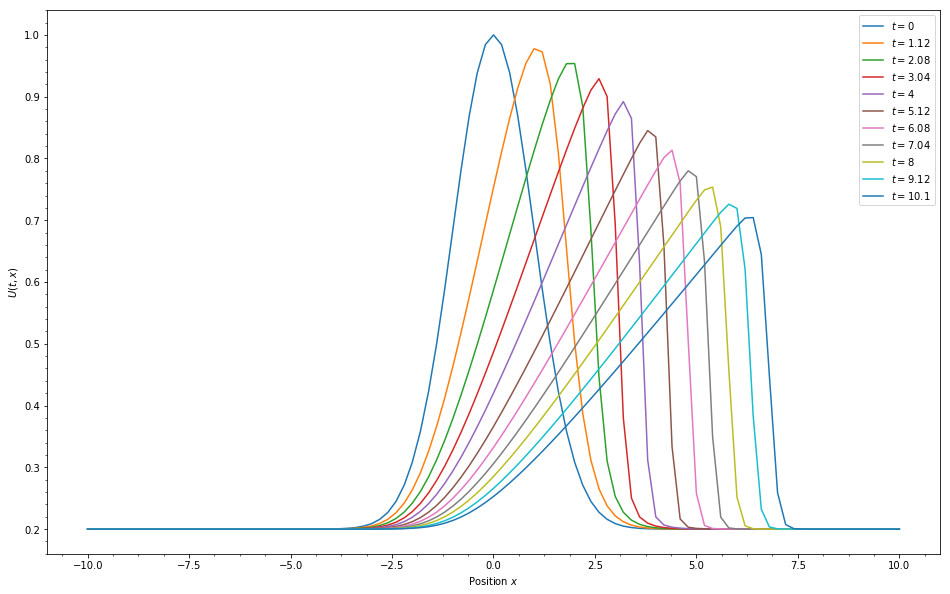

In [3]:
# Burgers' equation: conservative form

import numpy as np
import matplotlib.pyplot as plt

# Model Parameters
xmin = -10.0   # left boundary
xmax = +10.0   # right boundary
Nx = 101      # number of grid points (including boundary)
tend = 10.0    # end time
dtout = 1.0   # time interval for outputs

# Set up the grid.
x = np.linspace(xmin, xmax, Nx)
dx = (xmax - xmin) / (Nx - 1)
dt = 0.8 * dx

# Give the initial profile.
t = 0.0
U = 0.2 + 0.8 * np.exp(-0.5 * x**2)

# Initiate the plot.
fig = plt.figure(figsize=(16,10))
ax = fig.gca()
ax.plot(x, U, label=r"$t = {:.3G}$".format(t))
ax.set_xlabel(r"Position $x$")
ax.set_ylabel(r"$U(t,x)$")
ax.minorticks_on()

# Task1: Define the flux function given the left and the right states.
def riemann(Uleft, Uright):
    """Returns the flux given the left state Uleft and the right state Uright. """
    if Uleft >= 0:
        return 0.5*Uleft**2
    if Uright < 0:
        return 0.5*Uright**2
    return float("nan")

# Begin the simulation.
tout = t + dtout
while t < tend:
    # Task2: Implement the update with a finite volume method.
    Uold = np.copy(U)

    # Find the state at the next time step, using upwind method.
    for ix in range(1, Nx - 1):
        U[ix] = Uold[ix] - dt / dx * (riemann(Uold[ix], Uold[ix+1]) - riemann(Uold[ix-1], Uold[ix])) 

   
    
    pass
    t += dt

    # Monitor total U after every dtout.
    if t >= tout:
        plt.plot(x, U, label=r"$t = {:.3G}$".format(t))
        print("t, sum(U) = {:>6.3f}, {:>18.15e}".format(t, U[1:-1].sum()))
        tout += dtout

ax.legend()

print("Done.")
plt.show()

How does the conservation law hold this time?
Is the sum of $U$ now preserved to machine precision?
Why or why not?

It's preserved, but not to machine precision. Probably because we do not implement boudnary condtion. 

## Ghost Cells and Periodic Boundary Conditions

The simplest way to implement the boundary conditions for finite volume methods is to append a few more cells *outside* of the computational domain and assign them with values that are consistent with the intended boundary conditions at each time step.
These cells are called **ghost cells**, in contrast to the **active cells** inside the computational domain.
Then we can treat the boundary as normal interfaces as those inside the computational domain.

Suppose that we have a computational domain of $N$ active cells with two ghost cells on each side.  Then the data array would look like

<table>
  <tr>
    <td colspan="2" style="text-align:center;border-right-style:solid;">ghost cells</td>
    <td colspan="5" style="text-align:center;">active cells</td>
    <td colspan="2" style="text-align:center;border-left-style:solid;">ghost cells</td>
  </tr>
  <tr>
    <td width="40em">$U_0$</td>
    <td width="40em" style="border-right-style:solid;">$U_1$</td>
    <td width="40em">$U_2$</td>
    <td width="40em">$U_3$</td>
    <td width="40em">$\cdots$</td>
    <td width="40em">$U_N$</td>
    <td width="40em">$U_{N+1}$</td>
    <td width="40em" style="border-left-style:solid;">$U_{N+2}$</td>
    <td width="40em">$U_{N+3}$</td>
  </tr>
</table>

Then if we want to implement **periodic boundary conditions**, for example, we would assign the ghost cells with

\begin{equation}
  U_0 \leftarrow U_N,\ U_1 \leftarrow U_{N+1},\ U_{N+2} \leftarrow U_2,\ U_{N+3} \leftarrow U_3.
\end{equation}

Let's implement these boundary conditions to our code above.

t, sum(U) =  1.120, 3.002651309852400e+01
t, sum(U) =  2.080, 3.002651309852400e+01
t, sum(U) =  3.040, 3.002651309852400e+01
t, sum(U) =  4.000, 3.002651309852401e+01
t, sum(U) =  5.120, 3.002651309852401e+01
t, sum(U) =  6.080, 3.002651309852401e+01
t, sum(U) =  7.040, 3.002651309852400e+01
t, sum(U) =  8.000, 3.002651309852400e+01
t, sum(U) =  9.120, 3.002651309852401e+01
t, sum(U) = 10.080, 3.002651309852401e+01
Done.


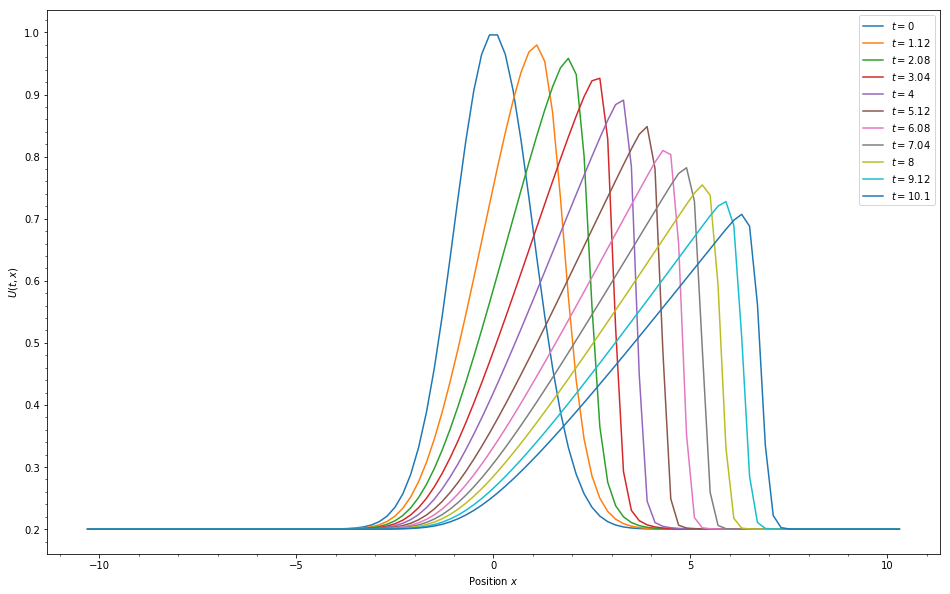

In [6]:
# Burgers' equation with periodic boundary conditions

import numpy as np
import matplotlib.pyplot as plt

# Model Parameters
xmin = -10.0  # left boundary
xmax = +10.0  # right boundary
Nx = 100      # number of cells
Nghost = 2    # number of ghost cells
tend = 10.0   # end time
dtout = 1.0   # time interval for outputs

# Set up the grid, now containing (Nx + 2 * Nghost) cells.
dx = (xmax - xmin) / Nx
x = xmin + (np.arange(Nx + 2 * Nghost) - Nghost + 0.5) * dx  # Assign coordinates to the cell *centers*
dt = 0.8 * dx

# Give the initial profile.
t = 0.0
U = 0.2 + 0.8 * np.exp(-0.5 * x**2)

# Initiate the plot.
fig = plt.figure(figsize=(16,10))
ax = fig.gca()
ax.plot(x, U, label=r"$t = {:.3G}$".format(t))
ax.set_xlabel(r"Position $x$")
ax.set_ylabel(r"$U(t,x)$")
ax.minorticks_on()

# Task: Copy your code above here and then modify as needed.
def riemann(Uleft, Uright):
    """Returns the flux given the left state Uleft and the right state Uright. """
    if Uleft >= 0:
        return 0.5*Uleft**2
    if Uright < 0:
        return 0.5*Uright**2
    return float("nan")

# Begin the simulation.
tout = t + dtout
while t < tend:
    # Task: Implement periodic boundary conditions here.
    Uold = np.copy(U)
    Uold[0:Nghost] = Uold[Nx:Nx+Nghost]
    Uold[Nx+Nghost:Nx+2*Nghost] = Uold[Nghost:2*Nghost]
    pass

    # Task: Copy your code above here and then modify as needed.
    for ix in range(1, Nx+2*Nghost - 1):
        U[ix] = Uold[ix] - dt / dx * (riemann(Uold[ix], Uold[ix+1]) - riemann(Uold[ix-1], Uold[ix])) 
    pass
    t += dt

    # Monitor total U after every dtout.
    if t >= tout:
        plt.plot(x, U, label=r"$t = {:.3G}$".format(t))
        print("t, sum(U) = {:>6.3f}, {:>18.15e}".format(t, U[Nghost:-Nghost].sum()))
        tout += dtout

ax.legend()

print("Done.")
plt.show()

How does the conservation law hold this time?
Is the sum of $U$ now preserved to machine precision?
Why or why not?

Now it's conserved to machine precision, since now the flux is conserved everywhere with the help of boundary condition.

## A Hyperbolic System: Euler Equations

An ideal fluid in 1D can be described by the **Euler equations**, which read

\begin{equation}
  \frac{\partial}{\partial t}
  \left(\begin{array}{c}
    \rho\\
    \rho u\\
    E
  \end{array}\right) +
  \frac{\partial}{\partial x}
  \left(\begin{array}{c}
    \rho u\\
    \rho u^2 + p\\
    (E + p)u
  \end{array}\right) = 0,
\end{equation}

where $\rho$ is the density, $u$ is the velocity, $E$ is the *total* energy density (internal and kinetic), and $p$ is the pressure.
This is a system of *three* conservation laws for density, linear momentum, and energy, respectively.
The system is closed by the **equation of state**

\begin{equation}
  E = \frac{p}{\gamma - 1} + \frac{1}{2}\rho u^2,
\end{equation}

where $\gamma$ is the adiabatic index.

In a finite volume method for this case, then, each cell contains *three* variables, i.e., a vector.

Solving the Riemann problem here is, not surprisingly, very involved.
There exist quite a few methods to solve the problem efficiently, albeit approximately.
We provide here one solution, called **Roe solver**, which uses linear approximation of the system while correctly capturing the shock structure, if any.

In [7]:
gamma = 5/3  # adiabatic index

def rsolver(wl, wr):
    """Returns the flux vector given the left state wl and the right state wr.  The state vectors are organized as
    
        wl[0]: left mass density; wr[0]: right mass density;
        wl[1]: left velocity;     wr[1]: right velocity;
        wl[2]: left pressure;     wr[2]: right pressure;
        
    The returned flux vector is for the conserved variables (rho, rho*u, E).
    
    Note: the adiabatic index gamma must be defined *before* using this function.
    """
    import math
    import numpy as np
    
    # Decompose the states.
    rhol, ul, pl = wl
    rhor, ur, pr = wr
    
    # Compute Roe-averaged state
    sqrtdl = math.sqrt(rhol)   
    sqrtdr = math.sqrt(rhor)
    isdlpdr = 1 / (sqrtdl + sqrtdr)
    
    roed = sqrtdl * sqrtdr
    roevx = (sqrtdl * ul + sqrtdr * ur) * isdlpdr
    # The enthalpy H=(E+P)/d is averaged sqrtdl*hl = sqrtdl*(el+pl)/dl = (el+pl)/sqrtdl
    el = pl / (gamma - 1) + 0.5 * rhol * ul**2
    er = pr / (gamma - 1) + 0.5 * rhor * ur**2
    roeh = ((el + pl) / sqrtdl + (er + pr) / sqrtdr) * isdlpdr
    
    # Compute sound speed in L,R, and Roe-averaged state
    cl = math.sqrt(gamma * pl / rhol)
    cr = math.sqrt(gamma * pr / rhor)
    q = max([roeh - 0.5 * roevx**2, 0.0])
    a = math.sqrt((gamma - 1) * q)

    # Compute the max/min wave speeds based on L/R and Roe-averaged values
    al = min([roevx - a, ul - cl])
    ar = max([roevx + a, ur + cr])
    bp = max([ar, 0.0])
    bm = min([al, 0.0])
        
    # Compute L/R fluxes along the lines bm/bp: F_L - (S_L)U_L; F_R - (S_R)U_R
    fl = np.zeros(3,)
    fr = np.zeros(3,)
    
    fl[0] = rhol * (ul - bm)
    fr[0] = rhor * (ur - bp)
    fl[1] = rhol * ul * (ul - bm) + pl
    fr[1] = rhor * ur * (ur - bp) + pr
    fl[2] = el * (ul - bm) + pl * ul
    fr[2] = er * (ur - bp) + pr * ur
    
    tmp = 0.5 * (bp + bm) / (bp - bm) if bp != bm else 0.0
    return 0.5 * (fl + fr) + (fl - fr) * tmp

## Shock-tube Problem and Non-reflecting Boundary Conditions

Now, take your time and try generalize our code for solving Burgers' equation to one that solves Euler's equations.

Consider a **shock tube**, in which a 1D pipe is separated by a divider at $x = 0$ into two compartments and the divider is suddenly removed at $t = 0$.  Write your initial conditions as follows.

\begin{aligned}
  \rho = 3, u = 0, p = 3, \quad & \textrm{if}\ x < 0,\\
  \rho = 1, u = 0, p = 1, \quad & \textrm{if}\ x > 0.
\end{aligned}

Note that this system is *not* periodic, so we need to change our boundary conditions.
Write your boundary conditions as follows.

\begin{equation}
  U_0 \leftarrow U_2,\ U_1 \leftarrow U_2,\ U_{N+2} \leftarrow U_{N+1},\ U_{N+3} \leftarrow U_{N+1}.
\end{equation}

In other words, copy the values in the last active cell before boundary out into the ghost cells.  This boundary condition is called **non-reflecting boundary condition**.

Use a computational domain of $-2 \le x \le 2$ and run the code up to $t = 1$.

In [5]:
# Implement your code for solving a shock-tube problem.

How does each variable—density, velocity, and pressure—evolve with time?

If you let the simulation run much longer, what happens?